In [4]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df=pd.read_pickle("/content/drive/My Drive/input/LSWMD.pkl")
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
734734,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",741.0,lot44427,15.0,[],[]
400015,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",999.0,lot23941,25.0,[],[]
589972,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot36824,25.0,[],[]
194441,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1930.0,lot12337,21.0,[],[]
760334,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45462,6.0,[],[]


In [6]:
#웨이퍼 인덱스 삭제
df = df.drop(['waferIndex'], axis = 1)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType
174475,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6065.0,lot11156,[],[]
459952,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot28326,[],[]
336175,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",11067.0,lot20260,[],[]
568953,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot35652,[],[]
443439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot27121,[],[]


In [7]:
#각 웨이퍼 마다 크기를 waferMapDim에 저장
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
481727,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",515.0,lot29842,[],[],"(25, 27)"
685701,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1233.0,lot42441,[[Test]],[[none]],"(41, 38)"
735631,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",741.0,lot44463,[[Test]],[[none]],"(33, 29)"
704731,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",516.0,lot43214,[],[],"(25, 27)"
654497,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot40933,[[Test]],[[none]],"(30, 34)"


In [8]:
#디펙타입을 숫자로 변형해 저장, test인지 train인지 trainTestNum에 저장
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8} #매핑타입을 숫자로 변경
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [9]:
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
548229,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot34333,[],[],"(49, 39)",[],[]
206833,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",710.0,lot13152,[],[],"(32, 29)",[],[]
754196,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",502.0,lot45214,[[Training]],[[none]],"(27, 25)",8,0
360910,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot21611,[[Training]],[[Random]],"(35, 40)",5,0
233640,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4553.0,lot14624,[],[],"(73, 79)",[],[]


In [10]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [11]:
#디펙이 없거나 레이블링 안된 개수
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()

#디펙있고 레이블링된 개수
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()

#none으로 레이블링된 개수
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [12]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)

#아무거나 하나 뽑아서 행렬로 나타내봤슴
print("{}", df_nonpattern['waferMap'][812])

{} [[0 0 0 0 0 0 0 0 0 0 2 1 2 1 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 1 2 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 1 1 1 1 1 1 2 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 2 2 1 1 2 2 1 2 1 1 1 1 1 2 1 2 1 2 0 0 0 0]
 [0 0 0 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 2 1 2 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 0 0]
 [0 1 2 2 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 0]
 [0 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 2 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2]
 [1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1]
 [1 1 1 1 2 1 1 2 2 1 1 1 2 2 2 2 1 1 1 1 1 1 1 2 1 1]
 [1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 1]
 [1 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 2 1 2 1]
 [1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 2 1]
 [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1]
 [0 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 0]
 [0 1 1

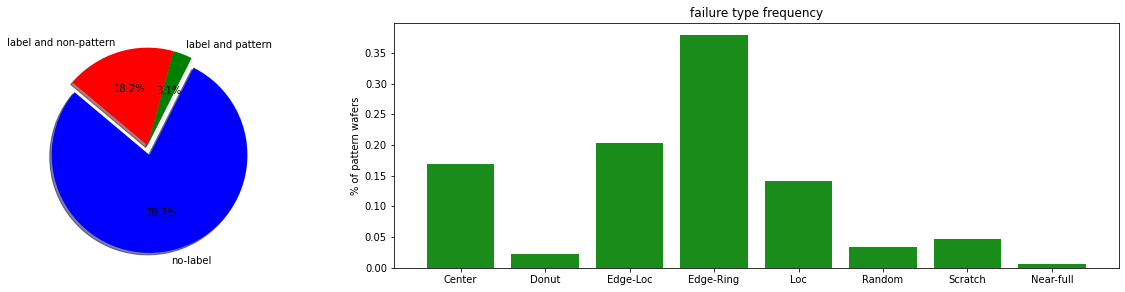

In [26]:
# label에 따라 빈도수를 나타낸다
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [14]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)] # 모든 waferMapDim를 (26, 26)으로 변경해서 sub_df에 저장
sub_wafer = sub_df['waferMap'].values # waferMap 의 값을 뽑아서 sub_wafer에 저장

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0: # 모든 sub_df에 대해 디펙타입이 0(none)인 경우 패스
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26))) # sw에 각 waferMap을 (1,26,26)으로 저장
    label.append(sub_df.iloc[i,:]['failureType'][0][0]) # 디펙타입

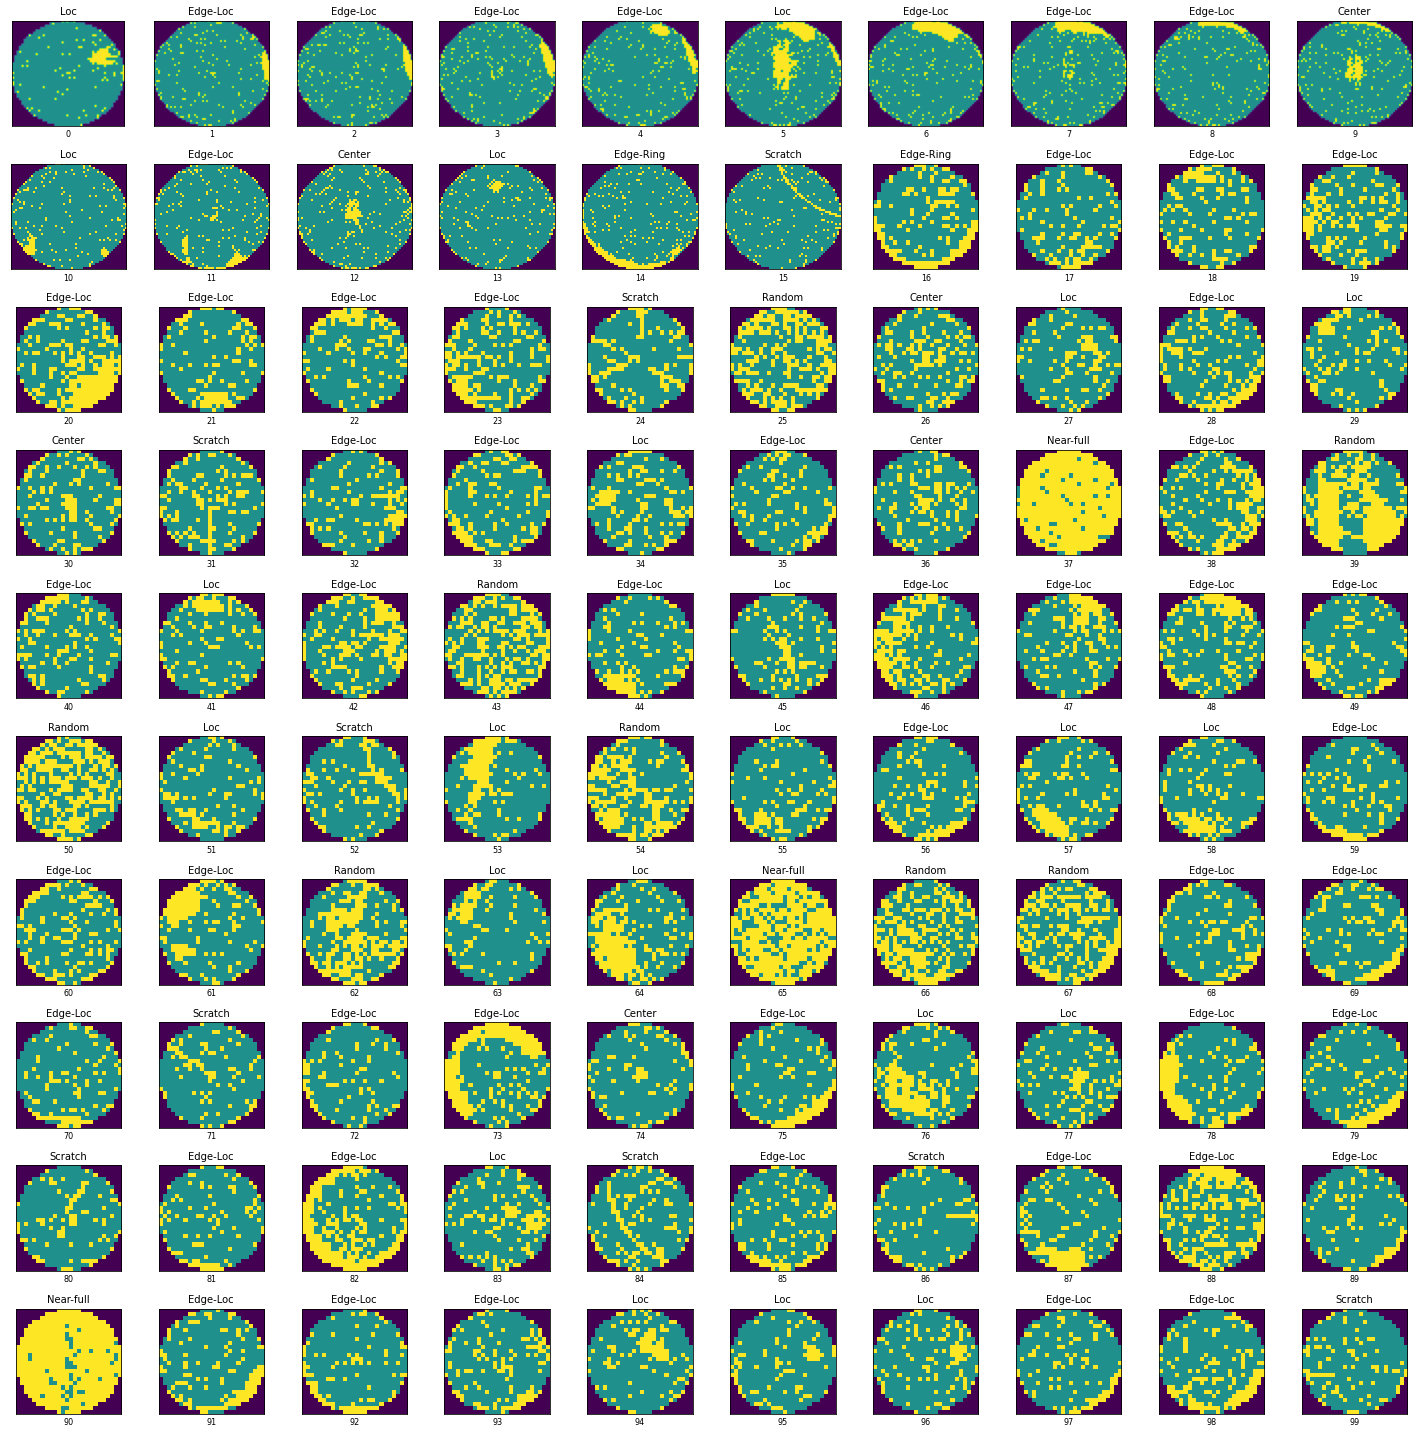

In [15]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [16]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [17]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


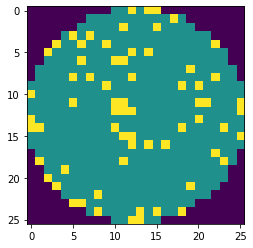

Faulty case : ['none'] 


In [18]:
# plot 1st data
plt.imshow(x[2040])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[2040]))

In [19]:
x = x.reshape((-1, 26, 26, 1))

In [20]:
# 정렬
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [21]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [22]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [23]:
new_x.shape

(14366, 26, 26, 3)

In [24]:
##이미지 제너레이터
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [25]:
epoch=30
batch_size=1024

In [27]:
# 이미지 제너레이팅 시작 start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 33s - loss: 0.1478
Epoch 2/30
15/15 - 1s - loss: 0.0942
Epoch 3/30
15/15 - 1s - loss: 0.0830
Epoch 4/30
15/15 - 1s - loss: 0.0720
Epoch 5/30
15/15 - 1s - loss: 0.0635
Epoch 6/30
15/15 - 1s - loss: 0.0571
Epoch 7/30
15/15 - 1s - loss: 0.0514
Epoch 8/30
15/15 - 1s - loss: 0.0464
Epoch 9/30
15/15 - 1s - loss: 0.0417
Epoch 10/30
15/15 - 1s - loss: 0.0373
Epoch 11/30
15/15 - 1s - loss: 0.0335
Epoch 12/30
15/15 - 1s - loss: 0.0303
Epoch 13/30
15/15 - 1s - loss: 0.0275
Epoch 14/30
15/15 - 1s - loss: 0.0250
Epoch 15/30
15/15 - 1s - loss: 0.0229
Epoch 16/30
15/15 - 1s - loss: 0.0211
Epoch 17/30
15/15 - 1s - loss: 0.0196
Epoch 18/30
15/15 - 1s - loss: 0.0182
Epoch 19/30
15/15 - 1s - loss: 0.0170
Epoch 20/30
15/15 - 1s - loss: 0.0159
Epoch 21/30
15/15 - 1s - loss: 0.0150
Epoch 22/30
15/15 - 1s - loss: 0.0142
Epoch 23/30
15/15 - 1s - loss: 0.0134
Epoch 24/30
15/15 - 1s - loss: 0.0127
Epoch 25/30
15/15 - 1s - loss: 0.0120
Epoch 26/30
15/15 - 1s - loss: 0.0115
Epoch 27/30
15/15 - 

In [28]:
encoder = models.Model(input_tensor, latent_vector)

In [29]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [30]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [31]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

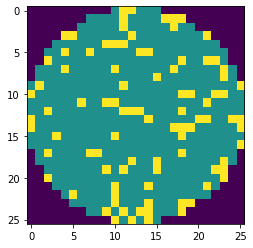

In [32]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

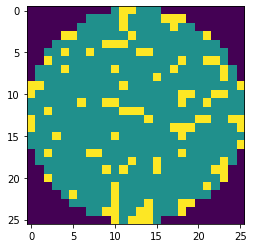

In [33]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [34]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [35]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))


In [36]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [37]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [38]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [39]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [40]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [41]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [42]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [44]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(layers.InputLayer(input_shape=(26, 26, 3)))
model.add(layers.Conv2D(filters=16, kernel_size=(3,3),input_shape=(26, 26, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy'],
)

filename = '/content/drive/My Drive/model_file_simpleCNN/checkpoint_CNN-{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5' # 가중치를 저장할 파일
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

history = model.fit(
    x_train,
    epochs=30,
    batch_size=1024,
    validation_data=y_train,
    callbacks=[checkpoint]
)

ValueError: ignored

In [59]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [48]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
9/9 - 2s - loss: 1.9156 - accuracy: 0.3904
Epoch 2/30
9/9 - 1s - loss: 0.8116 - accuracy: 0.7102
Epoch 3/30
9/9 - 1s - loss: 0.4568 - accuracy: 0.8521
Epoch 4/30
9/9 - 1s - loss: 0.2492 - accuracy: 0.9234
Epoch 5/30
9/9 - 1s - loss: 0.1277 - accuracy: 0.9638
Epoch 6/30
9/9 - 1s - loss: 0.0604 - accuracy: 0.9864
Epoch 7/30
9/9 - 1s - loss: 0.0301 - accuracy: 0.9941
Epoch 8/30
9/9 - 1s - loss: 0.0228 - accuracy: 0.9951
Epoch 9/30
9/9 - 1s - loss: 0.0123 - accuracy: 0.9976
Epoch 10/30
9/9 - 1s - loss: 0.0098 - accuracy: 0.9985
Epoch 11/30
9/9 - 1s - loss: 0.0062 - accuracy: 0.9988
Epoch 12/30
9/9 - 1s - loss: 0.0077 - accuracy: 0.9989
Epoch 13/30
9/9 - 1s - loss: 0.0107 - accuracy: 0.9979
Epoch 14/30
9/9 - 1s - loss: 0.0089 - accuracy: 0.9979
Epoch 15/30
9/9 - 1s - loss: 0.0095 - accuracy: 0.9986
Epoch 16/30
9/9 - 1s - loss: 0.0054 - accuracy: 0.9988
Epoch 17/30
9/9 - 1s - loss: 0.0041 - accuracy: 0.9991
Epoch 18/30
9/9 - 1s - loss: 0.0038 - accuracy: 0.9989
Epoch 19/30
9/9 - 1

AttributeError: ignored

In [47]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

AttributeError: ignored

In [ ]:
# accuracy plot 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()